`python3 -m pip install -U pandas plotly nbformat`

`pip install https://github.com/DCMLab/wavescapes/archive/refs/heads/johannes.zip`

In [55]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import pandas as pd
from wavescapes import Wavescape, legend_decomposition

from etl import get_dfts, get_mag_phase_mx, get_metadata, get_most_resonant, get_pcms, get_pcvs, test_dict_keys, \
    get_correlations, make_feature_vectors,  get_center_of_mass, get_mean_resonance, add_to_metrics, \
    get_partition_entropy, get_percentage_resonance, get_moment_of_inertia

from utils import get_coeff, most_resonant2color, long2utm

from wavescapes.color import circular_hue
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm


## Settings

In [2]:
DEBUSSY_REPO = '.'
DATA_FOLDER = '~/DATA/debussy_figures/data'
DATA_FOLDER = './data/data'
EXAMPLE_FNAME = 'l000_etude'
LONG_FORMAT = True

## Loading metadata
Metadata for all pieces contained in the dataset.

In [8]:
metadata = get_metadata(DEBUSSY_REPO)
metadata.columns

Metadata for 67 files.


Index(['rel_paths', 'last_mc', 'last_mn', 'length_qb', 'length_qb_unfolded',
       'all_notes_qb', 'TimeSig', 'KeySig', 'label_count', 'composer',
       'workTitle', 'movementNumber', 'movementTitle', 'workNumber', 'poet',
       'lyricist', 'arranger', 'copyright', 'creationDate', 'mscVersion',
       'platform', 'source', 'translator', 'musescore', 'ambitus', 'comments',
       'composed_end', 'composed_start', 'originalFormat', 'pdf',
       'staff_1_ambitus', 'staff_1_instrument', 'staff_2_ambitus',
       'staff_2_instrument', 'staff_3_ambitus', 'staff_3_instrument',
       'transcriber', 'typesetter', 'year', 'median_recording',
       'qb_per_minute', 'sounding_notes_per_qb', 'sounding_notes_per_minute'],
      dtype='object')

The column `year` contains composition years as the middle between beginning and end  of the composition span.

In [9]:
metadata.year.head(10)

fnames
l000_etude                     1915.0
l000_soirs                     1917.0
l009_danse                     1880.0
l066-01_arabesques_premiere    1888.0
l066-02_arabesques_deuxieme    1891.0
l067_mazurka                   1890.0
l068_reverie                   1890.0
l069_tarentelle                1890.0
l070_ballade                   1890.0
l071_valse                     1890.0
Name: year, dtype: float64

Series `median_recording` contains median recording times in seconds, retrieved from the Spotify API. the Spotify API.

In [10]:
metadata.median_recording.head(10)

fnames
l000_etude                     272.5530
l000_soirs                     145.8265
l009_danse                     124.5995
l066-01_arabesques_premiere    240.7780
l066-02_arabesques_deuxieme    213.9330
l067_mazurka                   175.9130
l068_reverie                   265.4265
l069_tarentelle                331.5290
l070_ballade                   396.0200
l071_valse                     221.4500
Name: median_recording, dtype: float64

Columns mirroring a piece's activity are currently:
* `qb_per_minute`: the pieces' lengths (expressed as 'qb' = quarterbeats) normalized by the median recording times; a proxy for the tempo
* `sounding_notes_per_minute`: the summed length of all notes normalized by the piece's duration (in minutes)
* `sounding_notes_per_qb`: the summed length of all notes normalized by the piece's length (in qb)
Other measures of activity could be, for example, 'onsets per beat/second' or 'distinct pitch classes per beat/second'.

In [6]:
#px.scatter(fname2activity.reset_index(), x='qb_per_minute', y='sounding_notes_per_minute', hover_data=['fnames'], trendline='ols', title="Do faster pieces have more sounding notes per minute?")

## Loading Pitch Class Vectors (PCVs)
An `{fname -> pd.DataFrame}` dictionary where each `(NX12)` DataFrame contains the absolute durations (expressed in quarter nots) of the 12 chromatic pitch classes for the `N` slices of length = 1 quarter note that make up the piece `fname`. The IntervalIndex reflects each slice's position in the piece. Set `pandas` to False to retrieve NumPy arrays without the IntervalIndex and column names.

In [11]:
pcvs = get_pcvs(DEBUSSY_REPO, pandas=True)
test_dict_keys(pcvs, metadata)
pcvs[EXAMPLE_FNAME].head(5)

Couldn't find matrices for the following files:
['l066-01_arabesques-premiere', 'l066-02_arabesques-deuxieme'].


,0,1,2,3,4,5,6,7,8,9,10,11
iv,,,,,,,,,,,,
"[0.0, 1.0)",0.167,0.0,0.0,0.334,0.0,0.000,0.0,0.0,1.334,0.0,0.167,0.0
"[1.0, 2.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,1.167,0.0,0.000,0.0
"[2.0, 3.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,0.167,0.0,0.000,0.0
"[3.0, 4.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,0.167,0.0,0.000,0.0
"[4.0, 5.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,1.167,0.0,0.000,0.0


## Loading Pitch Class Matrices
An `{fname -> np.array}` dictionary where each `(NxNx12)` array contains the aggregated PCVs for all segments that make up a piece. The square matrices contain values only in the upper right triangle, with the lower left beneath the diagonal is filled with zeros. The values are arranged such that row 0 correponds to the original PCV, row 1 the aggregated PCVs for all segments of length = 2 quarter notes, etc. For getting the segment reaching from slice 3 to 5 (including), i.e. length 3, the coordinates are `(2, 5)` (think x = 'length - 1' and y = index of the last slice included). The following example shows the upper left 3x3 submatrix where the first three entries (which are PCVs of size 12) correspond to the first three PCVs above, the first three of the second row to their sums padded with a 0-PCV, and the first three of the third row corresponding to the sum of row 0, padded with another 0-PCV.

In [8]:
pcms = get_pcms(DEBUSSY_REPO)
test_dict_keys(pcms, metadata)
pcms[EXAMPLE_FNAME][:3,:3]

Couldn't find matrices for the following files:
['l066-01_arabesques-premiere', 'l066-02_arabesques-deuxieme'].


array([[[0.167, 0.   , 0.   , 0.334, 0.   , 0.   , 0.   , 0.   , 1.334,
         0.   , 0.167, 0.   ],
        [0.167, 0.   , 0.   , 0.334, 0.   , 0.334, 0.   , 0.   , 1.167,
         0.   , 0.   , 0.   ],
        [0.167, 0.   , 0.   , 0.334, 0.   , 0.334, 0.   , 0.   , 0.167,
         0.   , 0.   , 0.   ]],

       [[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   ],
        [0.334, 0.   , 0.   , 0.668, 0.   , 0.334, 0.   , 0.   , 2.501,
         0.   , 0.167, 0.   ],
        [0.334, 0.   , 0.   , 0.668, 0.   , 0.668, 0.   , 0.   , 1.334,
         0.   , 0.   , 0.   ]],

       [[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   ],
        [0.501, 0.   , 0.   , 1.002, 0.   , 0.668, 0.   , 0.   , 2.668,
         0.   , 0.167, 0.   ]]])

## Loading Discrete Fourier Transforms
`{fname -> np.array}` containing `(NxNx7)` complex matrices. For instance, here's the first element, a size 7 complex vector with DFT coefficients 0 through 6:

In [9]:
dfts = get_dfts(DEBUSSY_REPO)
test_dict_keys(dfts, metadata)
dfts[EXAMPLE_FNAME][0,0]

Couldn't find matrices for the following files:
['l066-01_arabesques-premiere', 'l066-02_arabesques-deuxieme'].


array([ 2.002 +0.00000000e+00j, -0.4165+9.65904131e-01j,
       -0.9175-1.01065165e+00j,  1.334 +3.34000000e-01j,
       -0.2495+1.01065165e+00j, -0.4165-1.63390413e+00j,
        1.334 +1.11022302e-16j])

You can view the 7 complex numbers as magnitude-phase pairs

In [10]:
get_coeff(dfts[EXAMPLE_FNAME], 0, 0)

array([[ 2.  ,  0.  ],
       [ 1.05,  1.98],
       [ 1.36, -2.31],
       [ 1.38,  0.25],
       [ 1.04,  1.81],
       [ 1.69, -1.82],
       [ 1.33,  0.  ]])

or even as strings where the numbers are rounded and angles are shown in degrees:

In [11]:
get_coeff(dfts[EXAMPLE_FNAME], 0, 0,deg=True)

array([['2.0+0°'],
       ['1.05+247°'],
       ['1.36+132°'],
       ['1.38+346°'],
       ['1.04+256°'],
       ['1.69+104°'],
       ['1.33+0°']], dtype='<U9')

## Loading magnitude-phase matrices
`{fname -> np.array}` where each of the `(NxNx6x2)` matrices contains the 6 relevant DFT coefficients converted into magnitude-phase pairs where the magnitudes have undergone at least one normalization, i.e. are all within [0,1]. The files have been pre-computed and are loaded from g-zipped pickled matrices.

The parameter `normalization` allows for the values `('0c', 'post_norm', 'max_weighted', 'max')`.

In [21]:
norm_params = ('0c', True)
mag_phase_mx_dict = get_mag_phase_mx(DATA_FOLDER, norm_params=norm_params, long=False)
test_dict_keys(mag_phase_mx_dict, metadata)

print(f"Matrices have the shape NxNx6x2, where the last dimension holds magnitude and phase for each of the 6 coefficients.\n"
      f"E.g. '{EXAMPLE_FNAME}': {mag_phase_mx_dict[EXAMPLE_FNAME].shape}")


Couldn't find matrices for the following files:
['l066-01_arabesques_premiere', 'l066-02_arabesques_deuxieme', 'l099_cahier', 'l111-03_images_poissons', 'l117-11_preludes_danse', 'l136-06_etudes_huit', 'l136-12_etudes_accords'].


(284, 284, 6, 2)

Note that the phases (2nd column) are the same that we inspected above via `get_coeff()` whereas the magnitudes are now normalized by the first (now absent) coefficient 0.

In [22]:
mag_phase_mx_dict[EXAMPLE_FNAME][0,0]

array([[[ 5.38214271e-01,  1.97790855e+00],
        [ 7.49750250e-01, -2.30792065e+00],
        [ 8.33166833e-01,  2.45331397e-01],
        [ 7.49750250e-01,  1.81282734e+00],
        [ 8.71880604e-01, -1.82039166e+00],
        [ 6.66333666e-01,  8.32251143e-17]],

       [[ 4.44424363e-01,  2.51616207e+00],
        [ 4.99500500e-01, -2.25090725e+00],
        [ 6.66333666e-01,  0.00000000e+00],
        [ 1.00000000e+00,  1.76042734e+00],
        [ 7.72101656e-01, -1.65477615e+00],
        [ 3.32667333e-01,  8.33500769e-17]],

       [[ 4.10683603e-01, -2.09439510e+00],
        [ 1.66666667e-01,  2.09439510e+00],
        [ 3.33333333e-01,  0.00000000e+00],
        [ 1.00000000e+00,  1.04719755e+00],
        [ 7.44016936e-01, -1.04719755e+00],
        [ 3.33333333e-01, -3.14159265e+00]],

       ...,

       [[ 1.78632795e-01, -2.61799388e-01],
        [ 3.33333333e-01, -2.09439510e+00],
        [ 1.00000000e+00,  4.63647609e-01],
        [ 1.00000000e+00,  5.23598776e-01],
        [ 6.6

## Loading most resonant DFT coefficients
This cell depends on the previously loaded magnitude-phase matrices, i.e. a conscious choice of a normalization method has been made above.

`get_most_resonant` returns three `{fname -> nd.array}` dictionaries where for each piece, the three `(NxN)` matrices correspond to

1. the index between 0 and 5 of the most resonant of the six DFT coefficient 1 through 6
2. its magnitude
3. the inverse entropy of the 6 magnitudes

In [23]:
max_coeffs, max_mags, inv_entropies = get_most_resonant(mag_phase_mx_dict)
np.stack((max_coeffs[EXAMPLE_FNAME][:3,:3],
max_mags[EXAMPLE_FNAME][:3,:3],
inv_entropies[EXAMPLE_FNAME][:3,:3]))

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\ludov\anaconda3\en

array([[4.        , 3.        , 3.        , ..., 0.18687664, 0.18687664,
        0.18687664],
       [0.        , 3.        , 3.        , ..., 0.18687664, 0.18687664,
        0.18687664],
       [0.        , 0.        , 3.        , ..., 0.24929173, 0.18687664,
        0.18687664]])

# Center of mass

Computing the center of mass of each coefficient for all the pieces. Uses `mag_phase_mx_dict` as input and outputs the vertical center of mass as a fraction of the height of the wavescape. `get_center_of_mass` returns one `{fname -> list}` dictionary containing the 6 np.floats, one for each coefficient. 

In [82]:
center_of_masses = get_center_of_mass(mag_phase_mx_dict)
test_dict_keys(center_of_masses, metadata)
print(f"The example center of mass list has shape {len(center_of_masses[EXAMPLE_FNAME])}.")
center_of_masses[EXAMPLE_FNAME]

Couldn't find matrices for the following files:
['l066-01_arabesques_premiere', 'l066-02_arabesques_deuxieme', 'l099_cahier', 'l111-03_images_poissons', 'l117-11_preludes_danse', 'l136-06_etudes_huit', 'l136-12_etudes_accords'].
The example center of mass list has shape 6.


[0.26600092984200885,
 0.21161124832720876,
 0.2431548982901923,
 0.2216396770564771,
 0.2852747163984566,
 0.21447410060868968]

In [83]:
cols = [f"center_of_mass_{i}" for i in range(1,7)]
metadata_metrics = metadata.copy()


metadata_metrics = add_to_metrics(metadata_metrics, center_of_masses, cols)
metadata_metrics.head(1)


,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,TimeSig,KeySig,label_count,composer,...,median_recording,qb_per_minute,sounding_notes_per_qb,sounding_notes_per_minute,center_of_mass_1,center_of_mass_2,center_of_mass_3,center_of_mass_4,center_of_mass_5,center_of_mass_6
l000_etude,MS3,73,71,284.0,284.0,959.25,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,Claude Debussy,...,272.553,62.51995,3.377641,211.169938,0.266001,0.211611,0.243155,0.22164,0.285275,0.214474


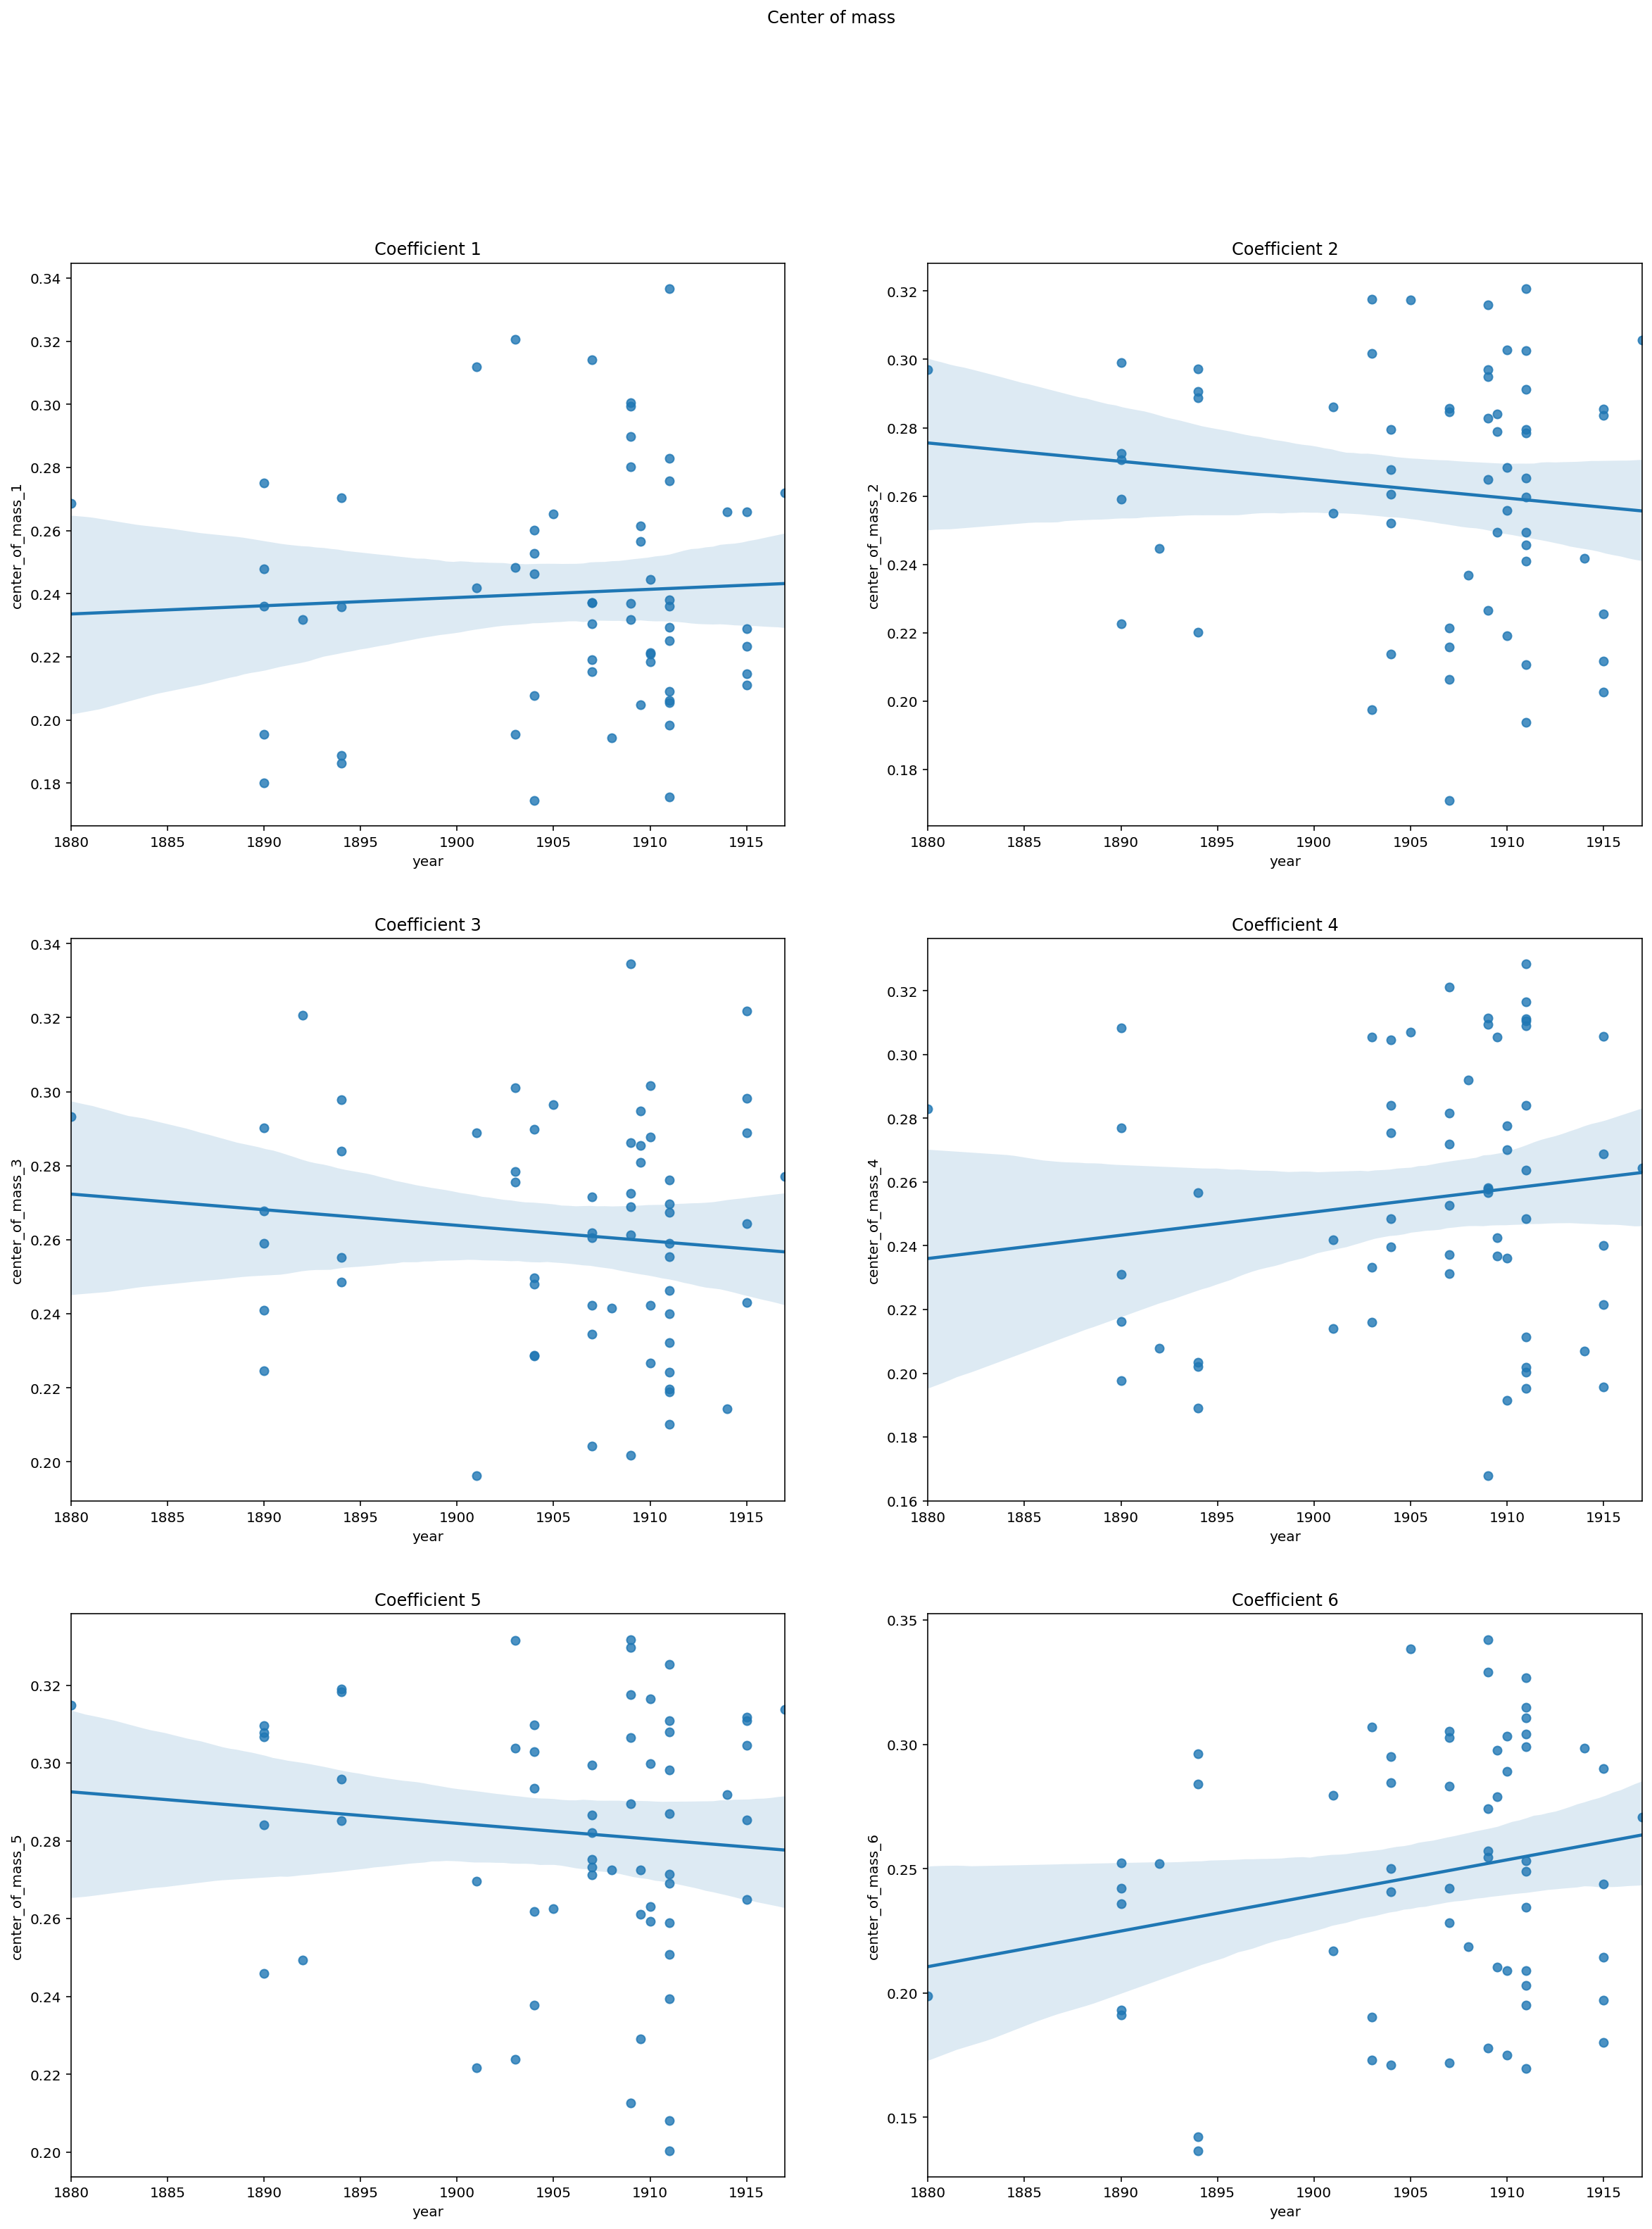

In [84]:
fig, axs = plt.subplots(3,2, figsize=(20,25))
axs = axs.flatten()

fig.suptitle('Center of mass')
columns_com = []

for i in range(1,7):
    axs[i-1].set_title(f"Coefficient {i}")
    columns_com.append(f"center_of_mass_{i}")
    sns.regplot(x='year', y=f"center_of_mass_{i}", data=metadata_metrics, ax=axs[i-1])
    
plt.savefig('figures/center_of_mass.png')

In [85]:
metadata_sm = metadata_metrics[metadata_metrics['center_of_mass_1'].notnull()]
scaler = StandardScaler()
metadata_sm[columns_com] = scaler.fit_transform(metadata_sm[columns_com])
for col in columns_com:
    y = metadata_sm[col]
    X = metadata_sm[['year', 'last_mc']]
    X = sm.add_constant(X)
    results = sm.OLS(y, X).fit()
    #print(results.summary())

# other method: group early and late pieces

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# Mean Resonance

Same concept as above but this time it is not weighted by the height

In [86]:
mean_resonances = get_mean_resonance(mag_phase_mx_dict)
test_dict_keys(mean_resonances, metadata)
print(f"The example mean resonance has shape {len(mean_resonances[EXAMPLE_FNAME])}.")
mean_resonances[EXAMPLE_FNAME]

Couldn't find matrices for the following files:
['l066-01_arabesques_premiere', 'l066-02_arabesques_deuxieme', 'l099_cahier', 'l111-03_images_poissons', 'l117-11_preludes_danse', 'l136-06_etudes_huit', 'l136-12_etudes_accords'].
The example mean resonance has shape 6.


array([0.05352486, 0.0653218 , 0.10388608, 0.15191741, 0.15174701,
       0.06172378])

In [87]:
cols = [f"mean_resonances_{i}" for i in range(1,7)]
metadata_metrics = add_to_metrics(metadata_metrics, mean_resonances, cols)
metadata_metrics.head(1)

,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,TimeSig,KeySig,label_count,composer,...,center_of_mass_3,center_of_mass_4,center_of_mass_5,center_of_mass_6,mean_resonances_1,mean_resonances_2,mean_resonances_3,mean_resonances_4,mean_resonances_5,mean_resonances_6
l000_etude,MS3,73,71,284.0,284.0,959.25,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,Claude Debussy,...,0.243155,0.22164,0.285275,0.214474,0.053525,0.065322,0.103886,0.151917,0.151747,0.061724


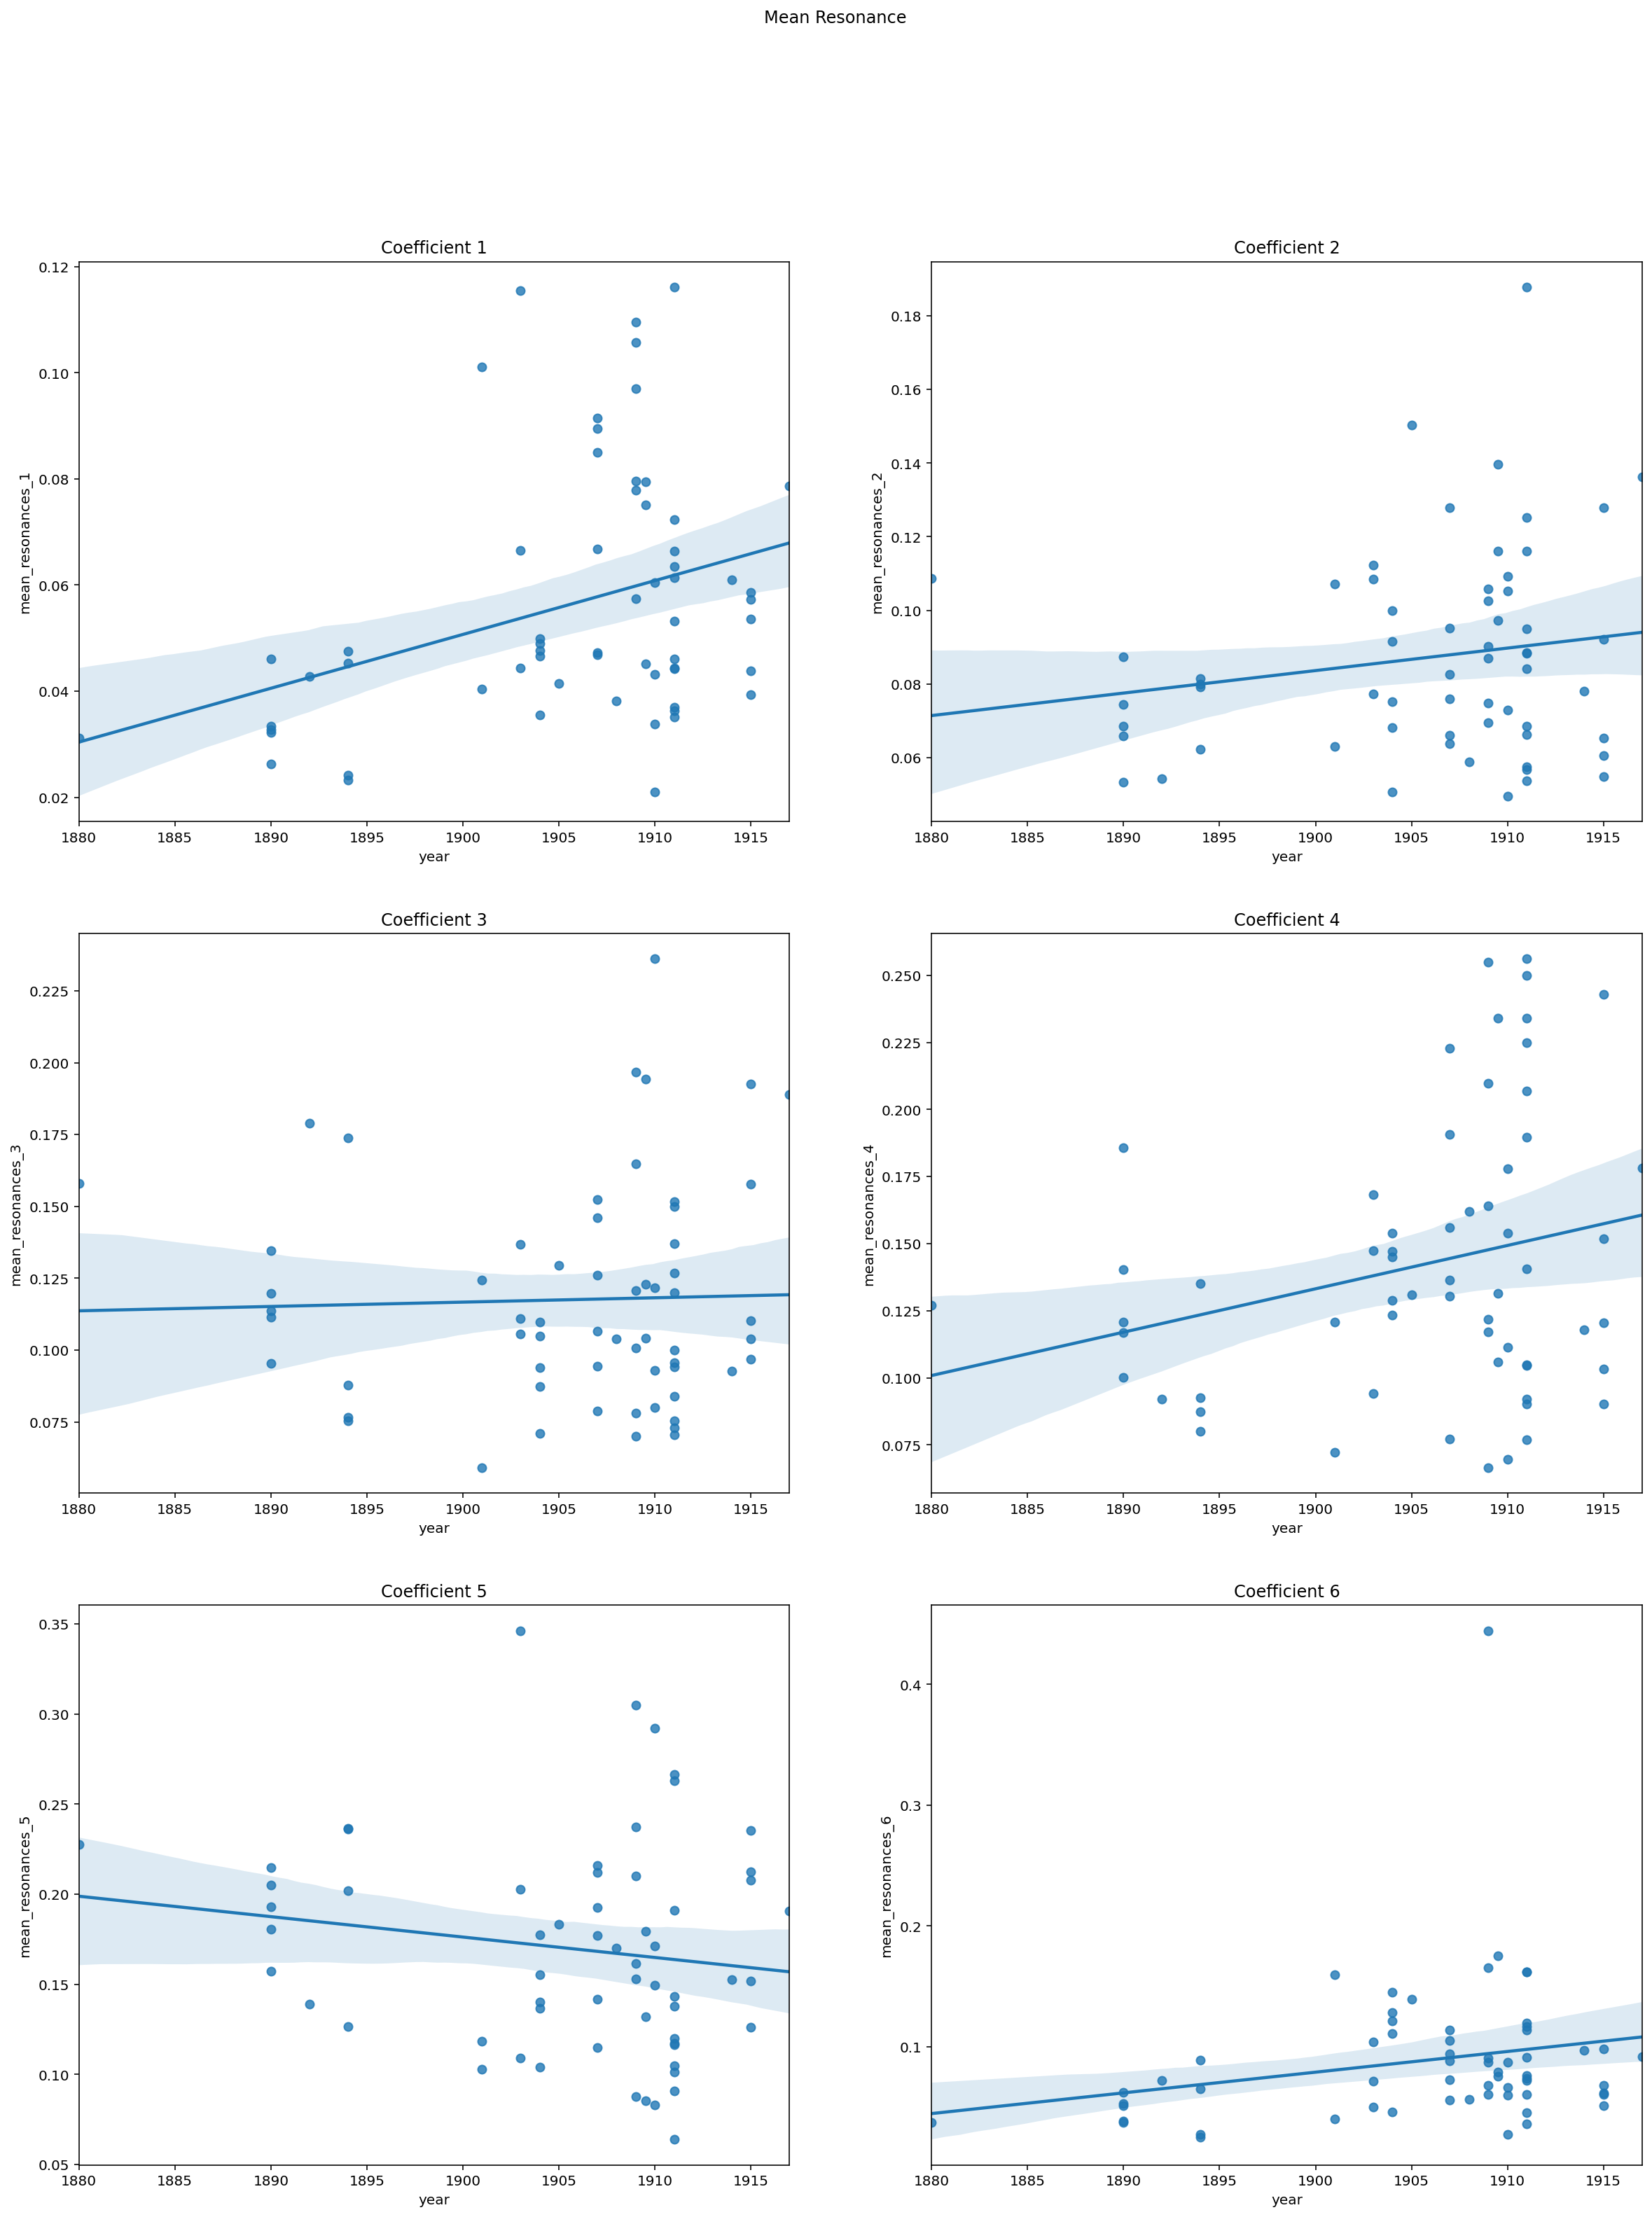

In [88]:
fig, axs = plt.subplots(3,2, figsize=(20,25))
axs = axs.flatten()

fig.suptitle('Mean Resonance')
columns_com = []

for i in range(1,7):
    axs[i-1].set_title(f"Coefficient {i}")
    columns_com.append(f"mean_resonances_{i}")
    sns.regplot(x='year', y=f"mean_resonances_{i}", data=metadata_metrics, ax=axs[i-1])
    
plt.savefig('figures/mean_resonance.png')

# Moment of Inertia 

“Moment of inertia” of coefficient n in the summary wavescape: I(n)=1NiS(n)wiyi2, where N is the total number of nodes in the wavescape, S(n) is the set of the indices of the nodes in the summary wavescapes that are attributed to coefficient n (i.e., where coefficient n is the most prominent among the six), w_i is the weight (opacity) of the i-th node in the summary wavescape, and y_i is the vertical coordinate of the i-th node in the summary wavescape


In [110]:
moments_of_inertia = get_moment_of_inertia(max_coeffs, max_mags)
test_dict_keys(moments_of_inertia, metadata)
print(f"The example mean resonance has shape {moments_of_inertia[EXAMPLE_FNAME].shape}.")
moments_of_inertia[EXAMPLE_FNAME]

[80089 80089 80089 80089 80089 80089 80089 80089 80089 80089 80089 80089
 80089 80089 79524 79524 79524 79524 79524 79524 78961 78961 78961 78961
 78961 78400 78400 78400 78400 78400 77841 77841 77841 77841 77284 77284
 77284 77284 76729 76729 76729 76729 76729 76176 76176 76176 76176 76176
 75625 75076 75076 74529 73984 73984 73441 72900 72900 72361 72361 71824
 71824 71289 71289 70756 70225 70225 69696 69169 69169 68644 68644 68121
 68121 61504 50625 50625 50176 49729 49284 48841 48841 48400]
[7744 7744 7744 7744 7569 7569 7569 7569 7569 7396 7396 7396 7396 7396
 7225 7225 7225 7225 7225 7056 7056 7056 6889 6889 6889 6724 6724 6561]
[32761 32761 32400 32400 32400 32400 32400 32041 32041 32041 32041 31684
 31684 31684 31329 30976 29929 29584 29584 29241 29241 29241 28900 28900
 28900 28561]
[178084 178084 178084 178084 178084 178084 178084 178084 178084 178084
 178084 178084 178084 178084 178084 178084 178084 178084 178084 177241
 177241 177241 177241 177241 177241 177241 177241 17724

array([0.00015947, 0.00053329, 0.01741228, 0.06447828, 0.03489523,
       0.00097629])

In [111]:
cols = [f"moments_of_inertia_{i}" for i in range(1,7)]
metadata_metrics = add_to_metrics(metadata_metrics, moments_of_inertia, cols)
metadata_metrics.head(1)

,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,TimeSig,KeySig,label_count,composer,...,mean_resonances_3,mean_resonances_4,mean_resonances_5,mean_resonances_6,moments_of_inertia_1,moments_of_inertia_2,moments_of_inertia_3,moments_of_inertia_4,moments_of_inertia_5,moments_of_inertia_6
l000_etude,MS3,73,71,284.0,284.0,959.25,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,Claude Debussy,...,0.103886,0.151917,0.151747,0.061724,0.000159,0.000533,0.017412,0.064478,0.034895,0.000976


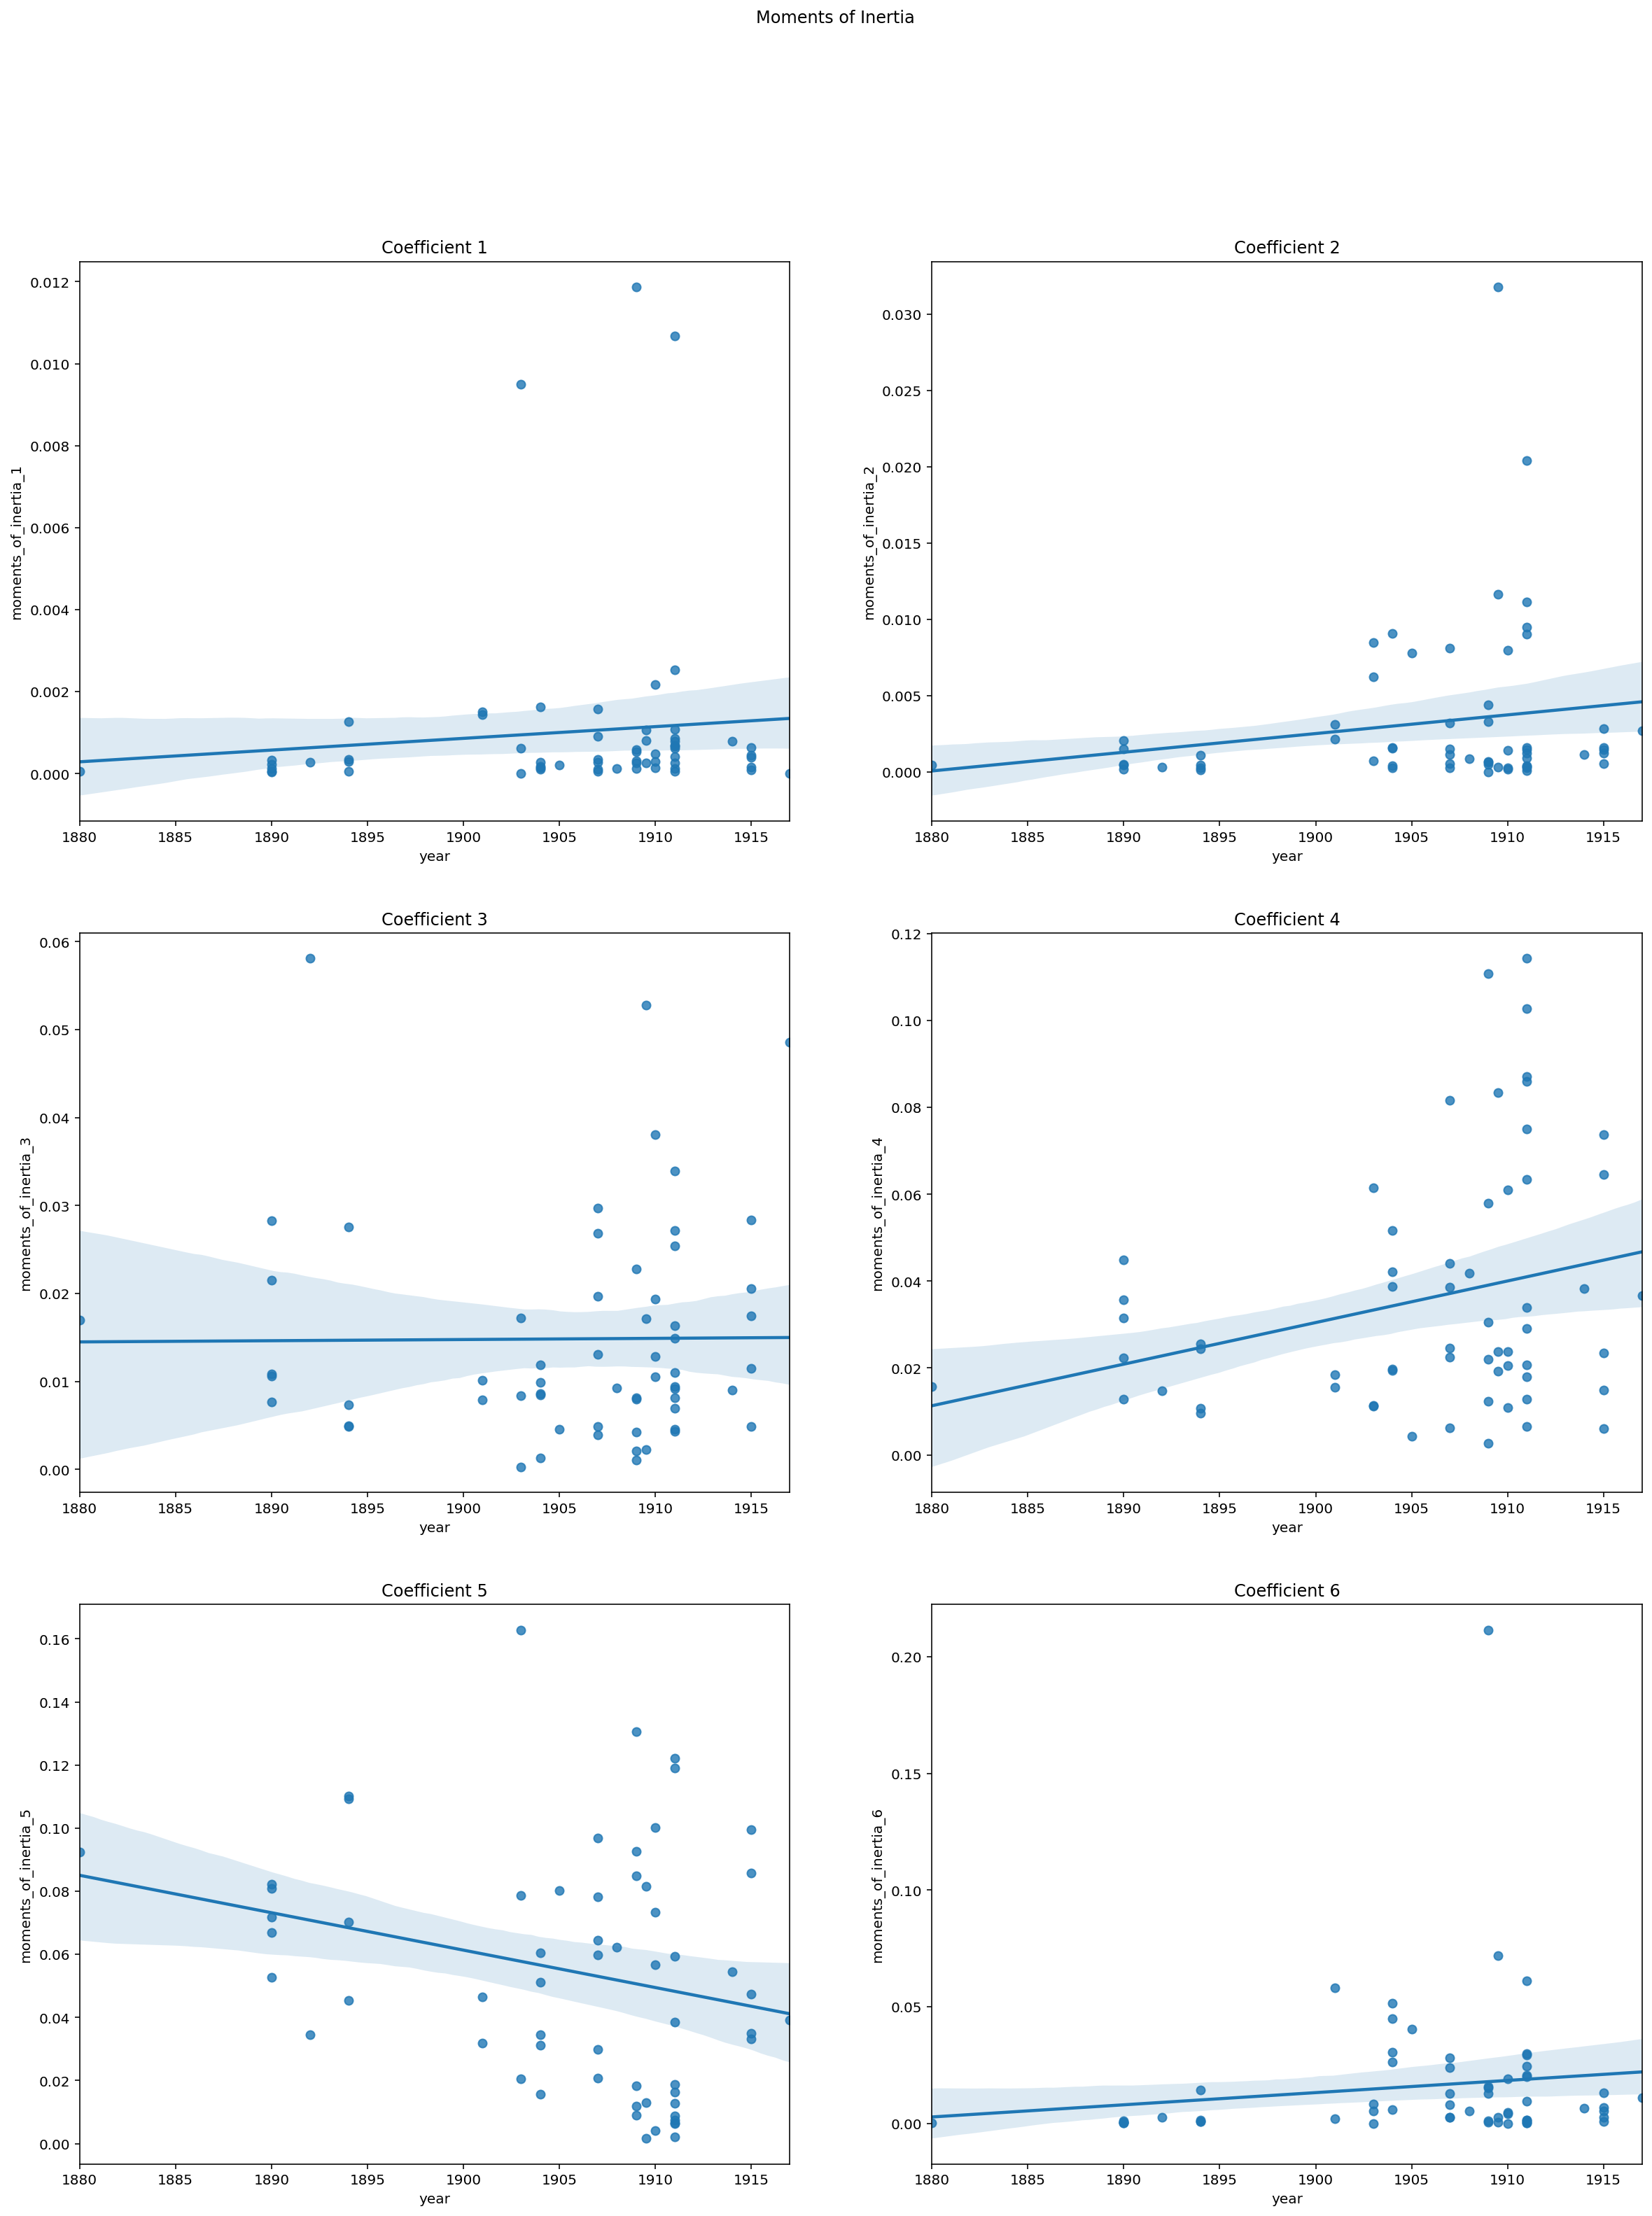

In [113]:
fig, axs = plt.subplots(3,2, figsize=(20,25))
axs = axs.flatten()

fig.suptitle('Moments of Inertia')
columns_com = []

for i in range(1,7):
    axs[i-1].set_title(f"Coefficient {i}")
    columns_com.append(f"moments_of_inertia_{i}")
    sns.regplot(x='year', y=f"moments_of_inertia_{i}", data=metadata_metrics, ax=axs[i-1])
    
plt.savefig('figures/moments_of_inertia.png')

In [114]:
metadata_sm = metadata_metrics[metadata_metrics['moments_of_inertia_1'].notnull()]
scaler = StandardScaler()
metadata_sm[columns_com] = scaler.fit_transform(metadata_sm[columns_com])
for col in columns_com:
    y = metadata_sm[col]
    X = metadata_sm[['year', 'last_mc']]
    X = sm.add_constant(X)
    results = sm.OLS(y, X).fit()
    print(results.summary())


                             OLS Regression Results                             
Dep. Variable:     moments_of_inertia_1   R-squared:                       0.012
Model:                              OLS   Adj. R-squared:                 -0.022
Method:                   Least Squares   F-statistic:                    0.3494
Date:                  Tue, 22 Feb 2022   Prob (F-statistic):              0.707
Time:                          12:26:39   Log-Likelihood:                -86.190
No. Observations:                    61   AIC:                             178.4
Df Residuals:                        58   BIC:                             184.7
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -27.8044     33.297

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\

# Prevalence of each coefficient

“Prevalence “ of coefficient n in a piece: W(n)=1NiS(n)wi where N is the total number of nodes in the wavescape, S(n) is the set of the indices of the nodes in the summary wavescapes that are attributed to coefficient n (i.e., where coefficient n is the most prominent among the six), and w_i is the weight (opacity) of the i-th node in the summary wavescape


In [116]:
percentage_resonance = get_percentage_resonance(max_coeffs)
test_dict_keys(percentage_resonance, metadata)
print(f"The example percentage resonance has shape {percentage_resonance[EXAMPLE_FNAME].shape}.")
percentage_resonance[EXAMPLE_FNAME]

Couldn't find matrices for the following files:
['l066-01_arabesques_premiere', 'l066-02_arabesques_deuxieme', 'l099_cahier', 'l111-03_images_poissons', 'l117-11_preludes_danse', 'l136-06_etudes_huit', 'l136-12_etudes_accords'].
The example percentage resonance has shape (6,).


array([0.49846261, 0.00101666, 0.07786154, 0.16114114, 0.25954672,
       0.00197134])

In [117]:
cols = [f"percentage_resonances_{i}" for i in range(1,7)]
metadata_metrics = add_to_metrics(metadata_metrics, percentage_resonance, cols)
metadata_metrics.head(1)

,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,TimeSig,KeySig,label_count,composer,...,moments_of_inertia_3,moments_of_inertia_4,moments_of_inertia_5,moments_of_inertia_6,percentage_resonances_1,percentage_resonances_2,percentage_resonances_3,percentage_resonances_4,percentage_resonances_5,percentage_resonances_6
l000_etude,MS3,73,71,284.0,284.0,959.25,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,Claude Debussy,...,0.017412,0.064478,0.034895,0.000976,0.498463,0.001017,0.077862,0.161141,0.259547,0.001971


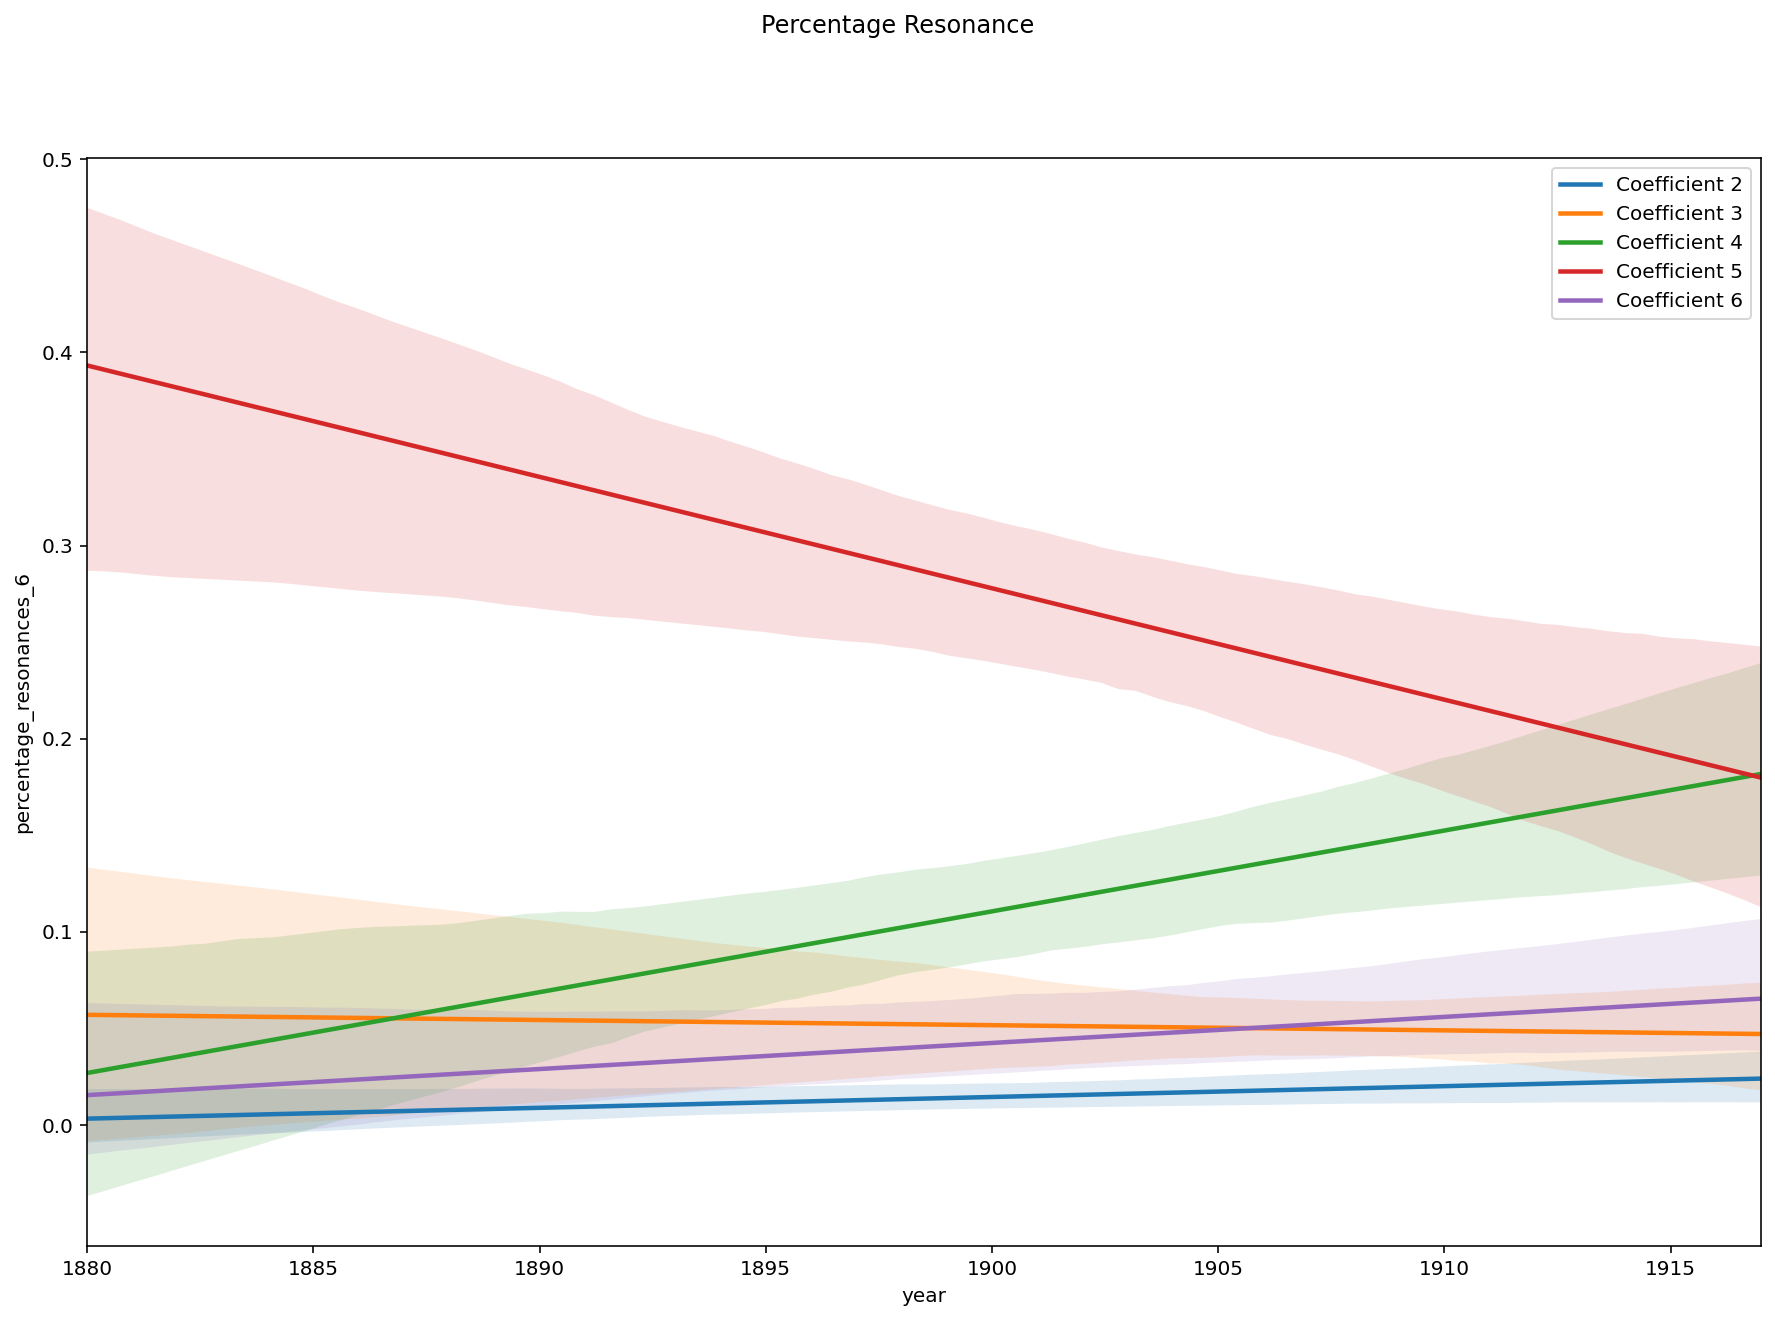

In [118]:
fig, axs = plt.subplots(1,1, figsize=(15,10))

fig.suptitle('Percentage Resonance')
columns_com = []

for i in range(2,7):
    columns_com.append(f"percentage_resonances_{i}")
    sns.regplot(x='year', y=f"percentage_resonances_{i}", data=metadata_metrics, scatter=False, label=f"Coefficient {i}")
    
plt.legend()
plt.savefig('figures/percentage_resonance.png')

In [119]:
metadata_sm = metadata_metrics[metadata_metrics['percentage_resonances_1'].notnull()]
scaler = StandardScaler()
metadata_sm[columns_com] = scaler.fit_transform(metadata_sm[columns_com])
for col in columns_com:
    y = metadata_sm[col]
    X = metadata_sm[['year', 'last_mc']]
    X = sm.add_constant(X)
    results = sm.OLS(y, X).fit()
    print(results.summary())


                               OLS Regression Results                              
Dep. Variable:     percentage_resonances_2   R-squared:                       0.040
Model:                                 OLS   Adj. R-squared:                  0.007
Method:                      Least Squares   F-statistic:                     1.221
Date:                     Tue, 22 Feb 2022   Prob (F-statistic):              0.302
Time:                             12:30:41   Log-Likelihood:                -85.297
No. Observations:                       61   AIC:                             176.6
Df Residuals:                           58   BIC:                             182.9
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\

In [51]:
percentage_resonance_weighted = get_percentage_resonance(max_coeffs, inv_entropies)
test_dict_keys(percentage_resonance_weighted, metadata)
print(f"The example percentage resonance has shape {percentage_resonance_weighted[EXAMPLE_FNAME].shape}.")
percentage_resonance_weighted[EXAMPLE_FNAME]

Couldn't find matrices for the following files:
['l066-01_arabesques_premiere', 'l066-02_arabesques_deuxieme', 'l099_cahier', 'l111-03_images_poissons', 'l117-11_preludes_danse', 'l136-06_etudes_huit', 'l136-12_etudes_accords'].
The example percentage resonance has shape (6,).


array([1.84134713e-05, 1.68494478e-04, 1.81500753e-02, 3.73207279e-02,
       5.67370571e-02, 2.92257347e-04])

In [52]:
cols = [f"percentage_resonances_weighted_{i}" for i in range(1,7)]
metadata_metrics = add_to_metrics(metadata_metrics, percentage_resonance_weighted, cols)
metadata_metrics.head(1)

,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,TimeSig,KeySig,label_count,composer,...,percentage_resonances_3,percentage_resonances_4,percentage_resonances_5,percentage_resonances_6,percentage_resonances_weighted_1,percentage_resonances_weighted_2,percentage_resonances_weighted_3,percentage_resonances_weighted_4,percentage_resonances_weighted_5,percentage_resonances_weighted_6
l000_etude,MS3,73,71,284.0,284.0,959.25,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,Claude Debussy,...,0.077862,0.161141,0.259547,0.001971,0.000018,0.000168,0.01815,0.037321,0.056737,0.000292


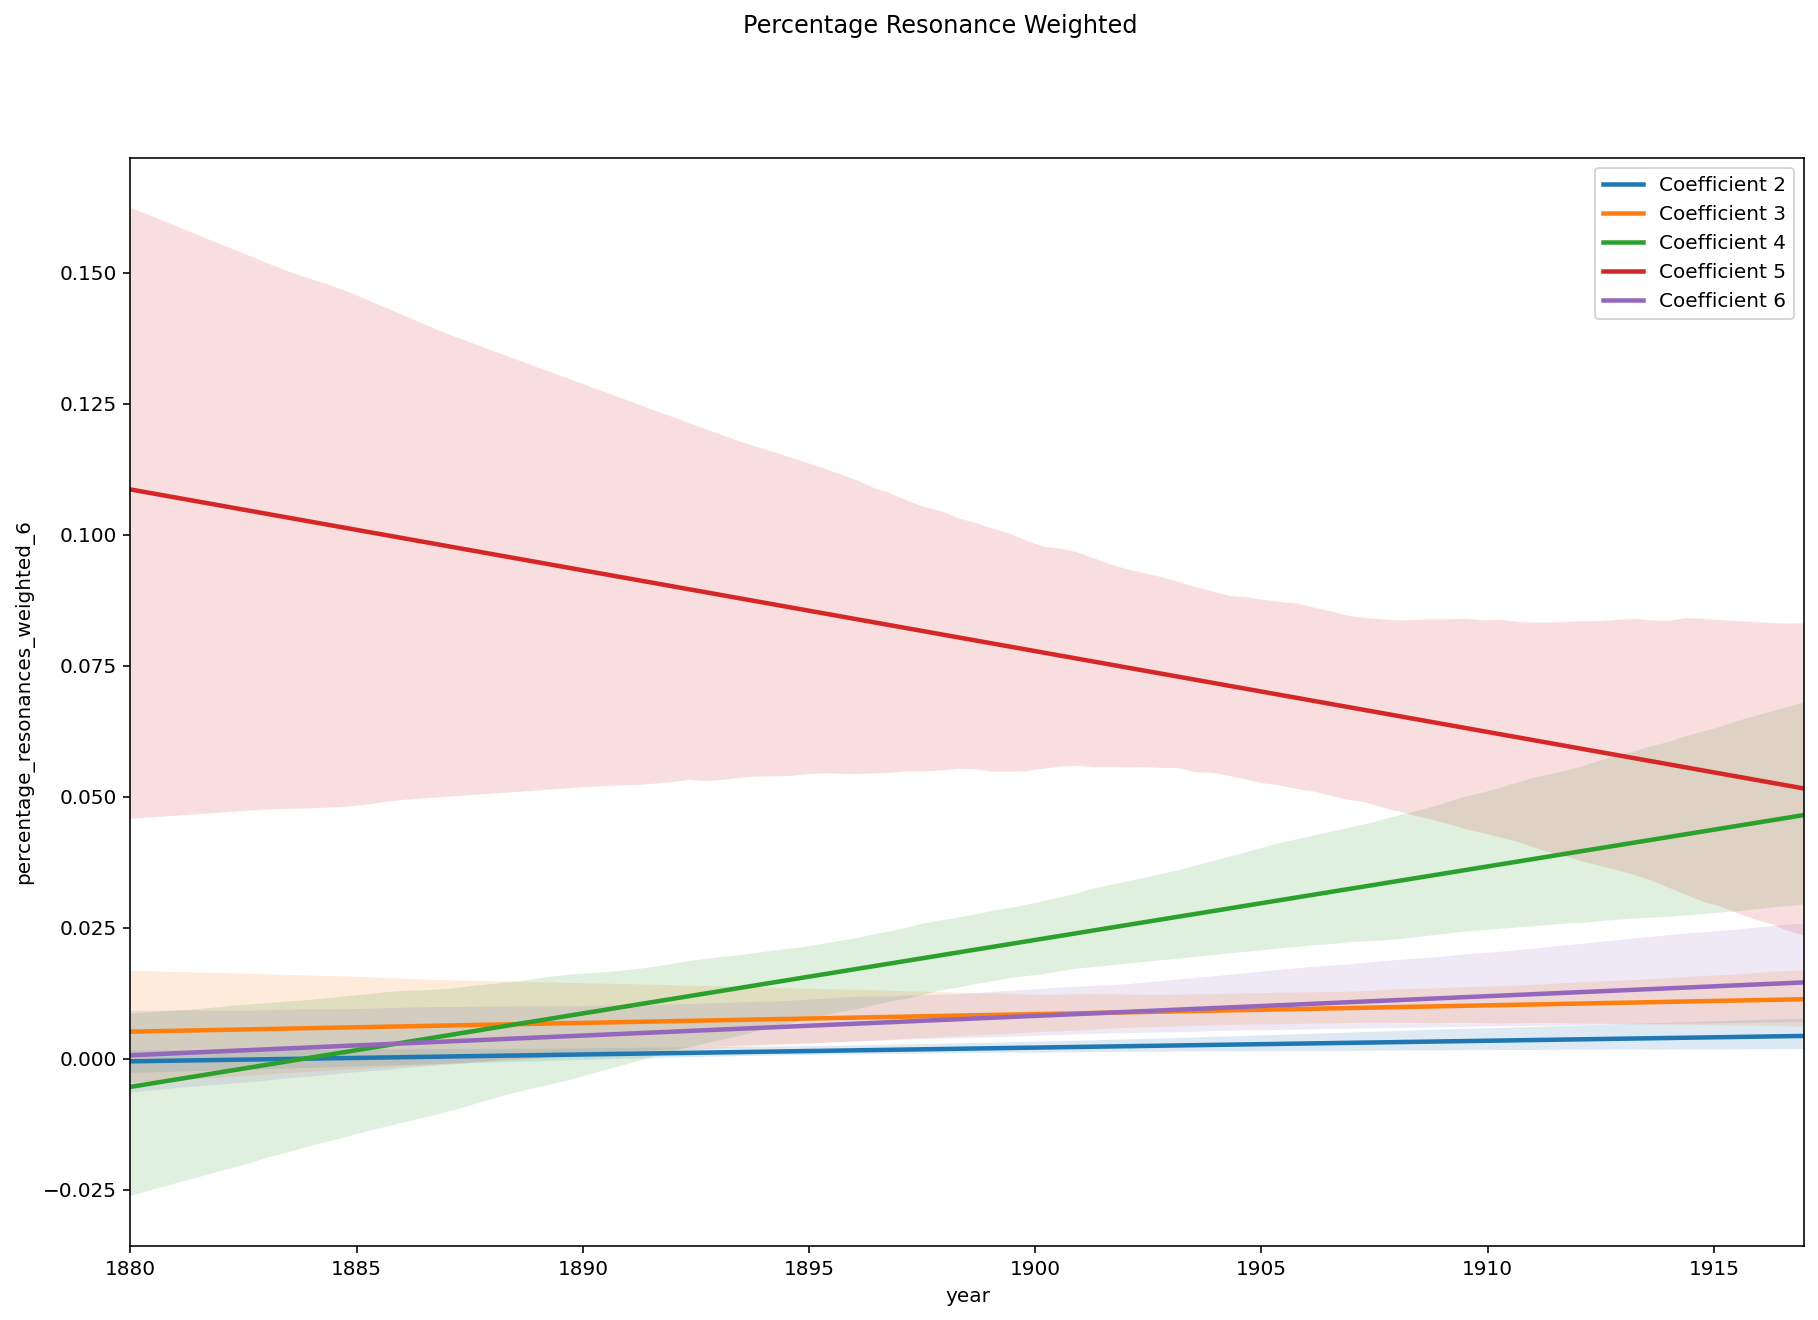

In [53]:
fig, axs = plt.subplots(1,1, figsize=(15,10))

fig.suptitle('Percentage Resonance Weighted')

for i in range(2,7):
    sns.regplot(x='year', y=f"percentage_resonances_weighted_{i}", data=metadata_metrics, scatter=False, label=f"Coefficient {i}")
    
plt.legend()
plt.savefig('figures/percentage_resonance_weighted.png')

# Measure Theoretic Entropy

Measure-theoretic entropy: Let A={A1,,Ak} be a (finite) partition of a probability space (X,P(X),): the entropy of the partition A is defined as H(A)=-i(Ai)(Ai). We can take X as the support of the wavescape, A as the set of the connected regions in the unified wavescape, and (Y)=(area of Y)/(area of X) for any subset Y of the wavescape


degree of fragmentation by entropy of the connected components' areas: Let A={A1,,Ak} be a (finite) partition of a probability space (X,P(X),): the entropy of the partition A is defined as H(A)=-i(Ai)(Ai). We can take X as the support of the wavescape, A as the set of the connected regions in the unified wavescape, and (Y)=(area of Y)/(area of X) for any subset Y of the wavescape.


In [ ]:
# takes quite long
partition_entropy = get_partition_entropy(max_coeffs)
test_dict_keys(partition_entropy, metadata)
#print(f"The example partition_entropy has shape {len(mean_resonances[EXAMPLE_FNAME])}.")
partition_entropy[EXAMPLE_FNAME]

In [ ]:
cols = 'partition_entropy'
metadata_metrics = add_to_metrics(metadata_metrics, partition_entropy, cols)
metadata_metrics.head(1)

In [121]:
metadata_metrics = pd.read_csv('metrics.csv')

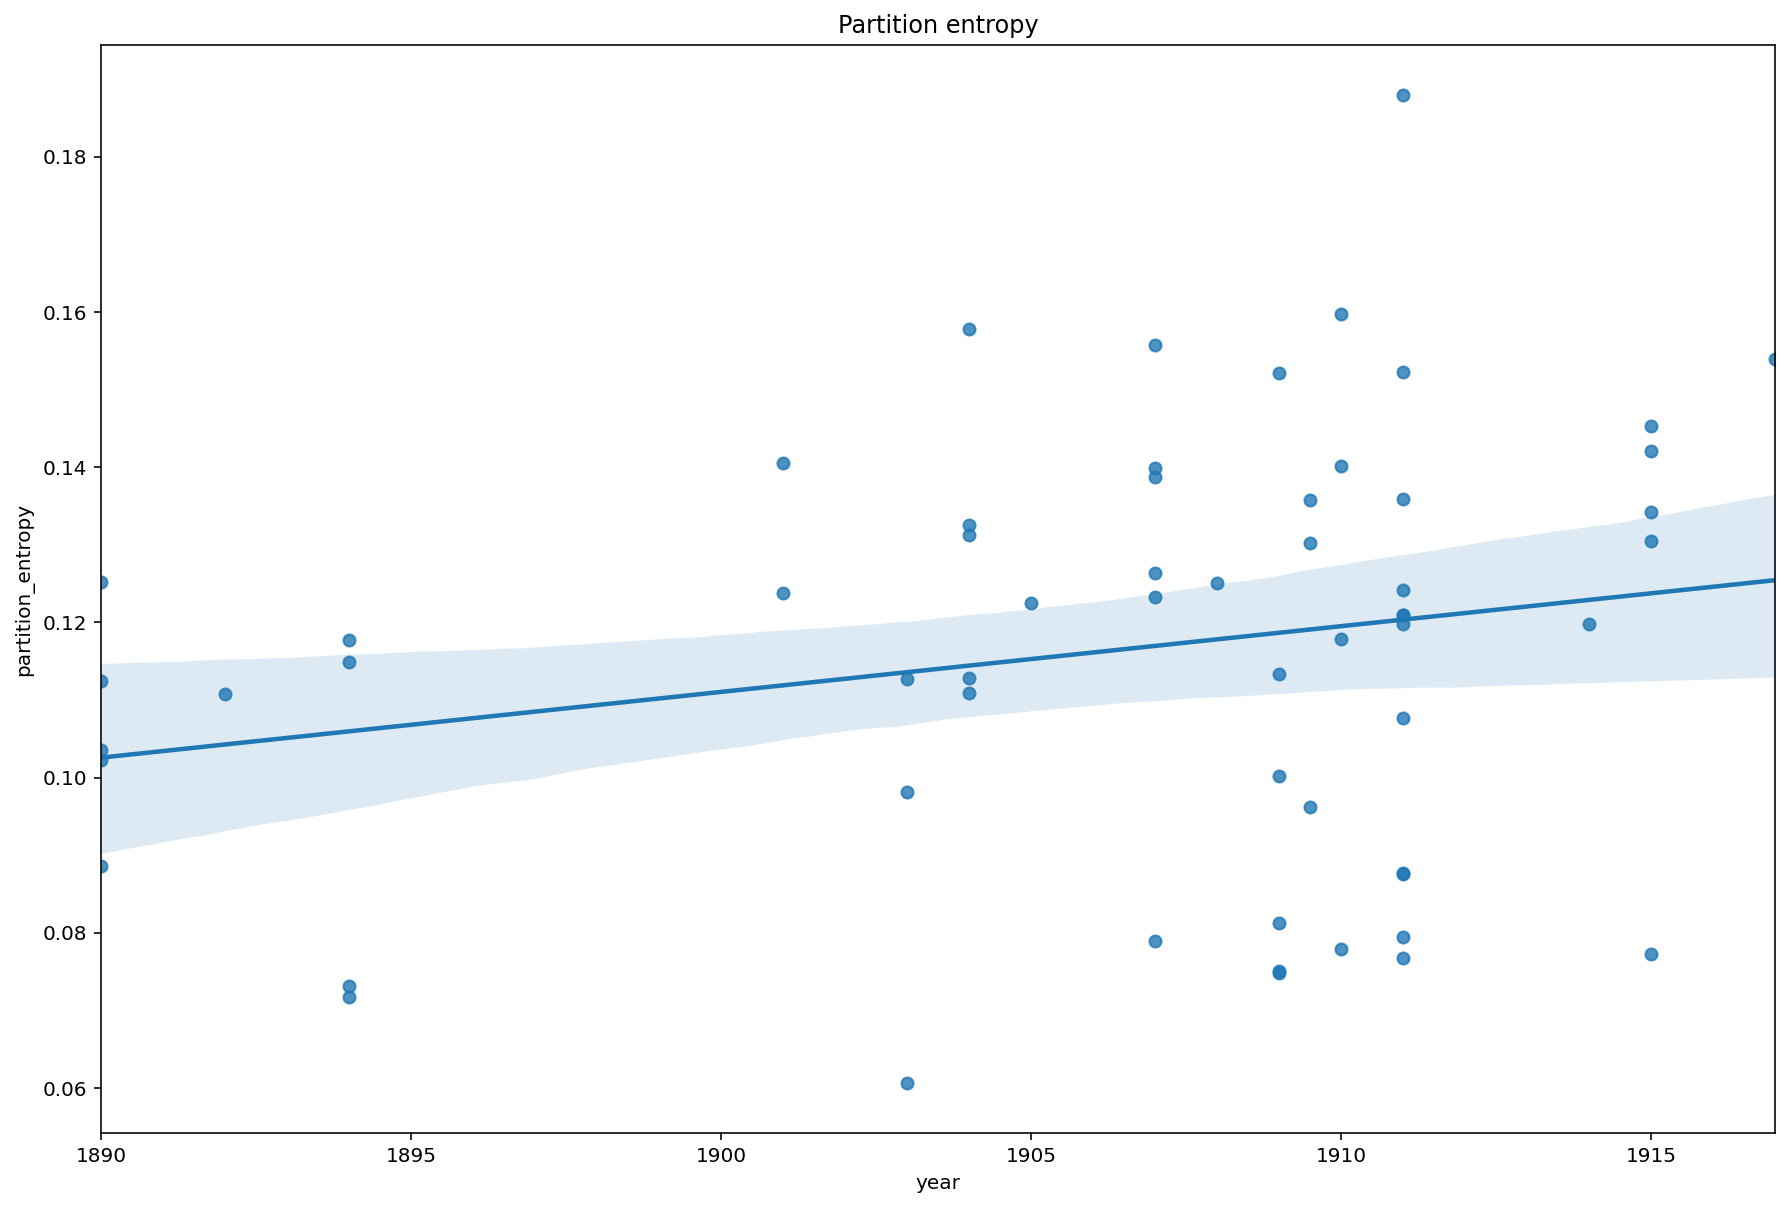

In [122]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
plt.title("Partition entropy")
sns.regplot(x='year', y='partition_entropy', data=metadata_metrics[metadata_metrics['year'] != 1880])
plt.savefig('figures/partition_entropy.png')

In [35]:
metadata_sm = metadata_metrics[metadata_metrics['partition_entropy'].notnull()]
scaler = StandardScaler()
metadata_sm['partition_entropy'] = scaler.fit_transform(np.array(metadata_sm['partition_entropy']).reshape(-1, 1))
y = metadata_sm['partition_entropy']
X = metadata_sm[['year', 'last_mc']]
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:      partition_entropy   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     2.024
Date:                Tue, 22 Feb 2022   Prob (F-statistic):              0.141
Time:                        11:15:45   Log-Likelihood:                -84.498
No. Observations:                  61   AIC:                             175.0
Df Residuals:                      58   BIC:                             181.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -61.2399     32.386     -1.891      0.0

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# Lower magnitude for all coefficients in higher hierarchical positions 

In [118]:
metadata_metrics.to_csv('metrics.csv')

## Loading major & minor coefficients

In [63]:
maj_min_coeffs = get_maj_min_coeffs(DEBUSSY_REPO)
test_dict_keys(maj_min_coeffs, metadata)
print(f"The example maj_min_coeffs have the shape {maj_min_coeffs[EXAMPLE_FNAME].shape}.")
maj_min_coeffs[EXAMPLE_FNAME][:3, :3]

Found matrices for all files listed in metadata.tsv.


(40470, 3)

## Loading pickled 9-fold vectors

The function is a shortcut for
* loading a particular kind of pickled normalized magnitude-phase-matrices
* loading pickled tritone, major, and minor coefficients
* concatenating them toegther

In [15]:
norm_params = ('0c', True)
ninefold_dict = make_feature_vectors(DATA_FOLDER, norm_params=norm_params, long=LONG_FORMAT)
test_dict_keys(ninefold_dict, metadata)
ninefold_dict[EXAMPLE_FNAME].shape

Found matrices for all files listed in metadata.tsv.


(40470, 9)

## Minimal example for drawing a wavescape

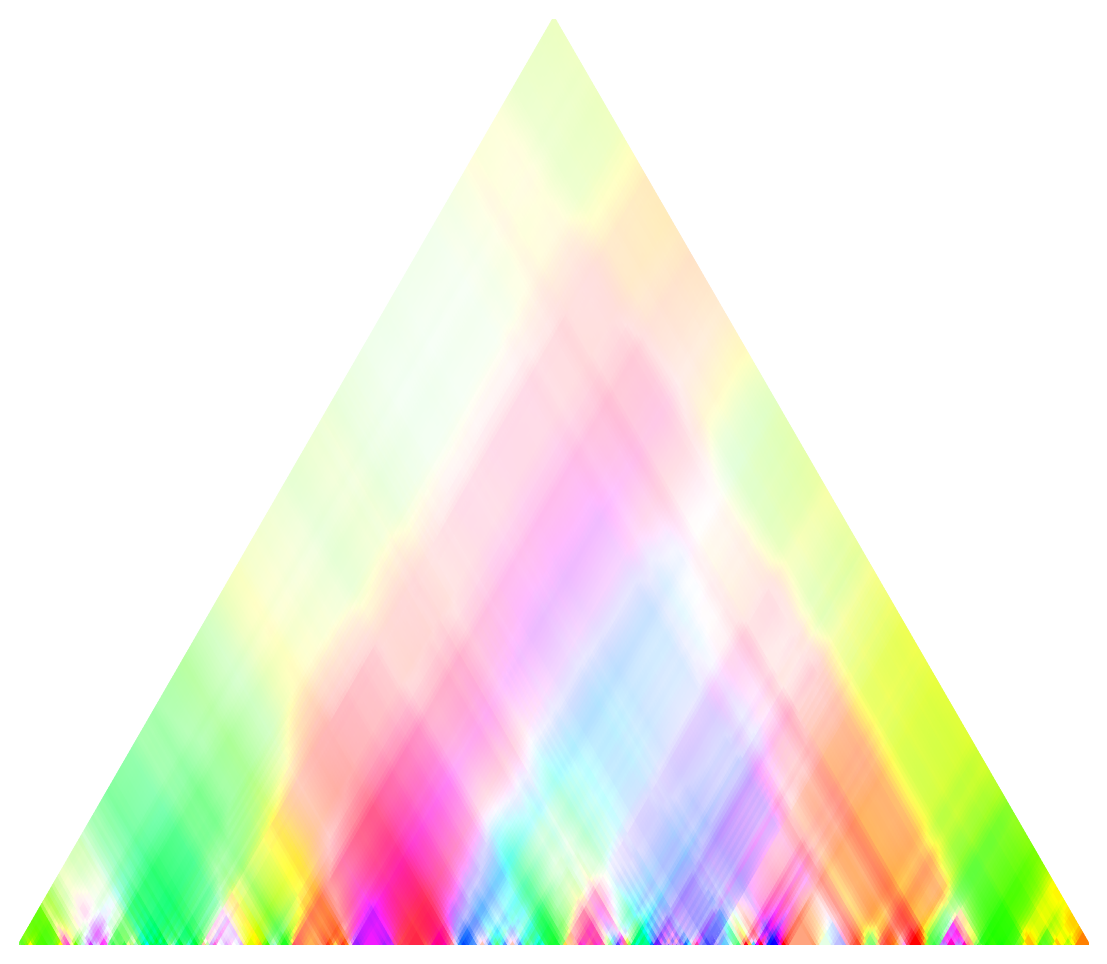

In [17]:
coeff_4_colors = circular_hue(mag_phase_mx_dict[EXAMPLE_FNAME][..., 3, :])
length = coeff_4_colors.shape[0]
width = 500 if length <= 250 else 2 * length
ws = Wavescape(coeff_4_colors, width=width)
ws.draw()

## Drawing a summary wavescapes

/home/hentsche/wavescapes/wavescapes/general.py:543: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['$0$', '', '$\pi/2$', '', '$\pi$', '', '$3\pi/2$', ''])


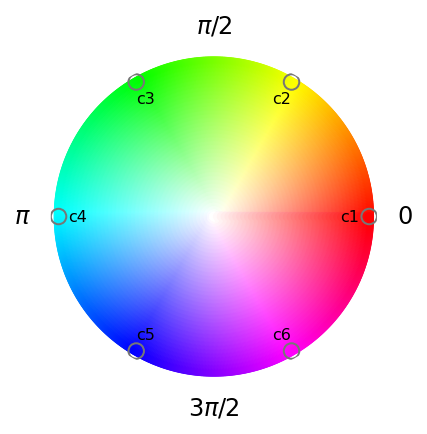

In [17]:
def make_pcv(position_of_one):
    return [0] * position_of_one + [1] + [0] * (11-position_of_one)
legend = {f'c{i+1}': (make_pcv(6-i), [2]) for i in range(0,6)}
legend_decomposition(legend, width=3, single_img_coeff=2)

In [18]:
max_coeff, max_mag, inv_entropy = max_coeffs[EXAMPLE_FNAME], max_mags[EXAMPLE_FNAME], inv_entropies[EXAMPLE_FNAME]
if LONG_FORMAT:
    max_coeff, max_mag, inv_entropy = long2utm(max_coeff), long2utm(max_mag), long2utm(inv_entropy)
draw_settings = dict(label_size=5, aw_per_tick=10, tick_factor=10, tight_layout=False)

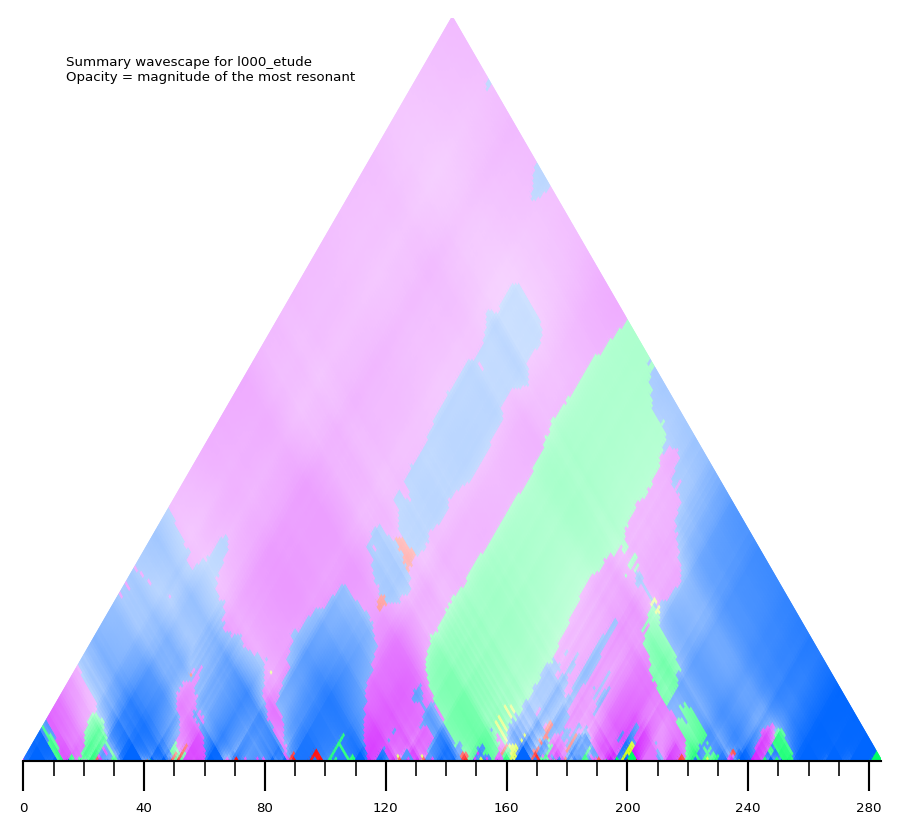

In [21]:
summary_colors = most_resonant2color(max_coeff, max_mag)
ws = Wavescape(summary_colors, width=width)
ws.draw()

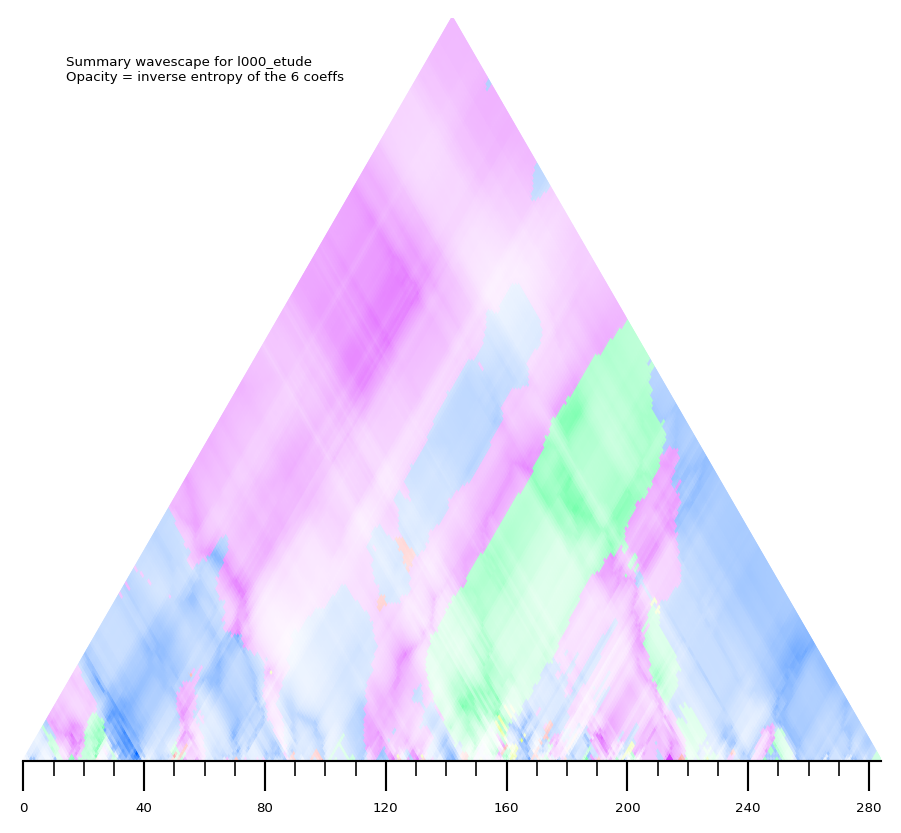

In [22]:
summary_colors = most_resonant2color(max_coeff, inv_entropy)
ws = Wavescape(summary_colors, width=width)
ws.draw()